<a href="https://colab.research.google.com/github/Togotogo98/Detecting_Polarising_Language/blob/main/Multiclass_Classifier_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Library and Installations**

In [ ]:
# Installing the latest versions of key machine learning and data processing libraries:
#   transformers: For using pre-trained transformer models
#   torch: PyTorch, a deep learning framework
#   datasets: A library for easily accessing and using datasets for NLP and other tasks
#   accelerate: For speeding up model training on multiple GPUs or TPUs
#   pandas: A data manipulation and analysis library
#   scikit-learn and matplotlib: For data visualization

!pip install transformers torch datasets accelerate pandas -U
!pip install scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfu

In [ ]:
# Importing essential libraries and modules:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import torch

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Data Mounting and Label Encoding**

In [ ]:
# Mounting Google Drive to the Colab environment to access files stored in Google Drive:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading a CSV file from Google Drive into a pandas DataFrame.
# The file is located at the specified path in Google Drive [Note: Change path based on the file location]:

comments = pd.read_csv('/content/drive/My Drive/Masters Backup/polarising_comments_V_2.csv', encoding='ISO-8859-1')

# The columns of the DataFrame are renamed to 'text' and 'label' for clarity:
comments.columns = ['text', 'label']
print(comments.head())

                                                text  \
0  Its more about stubbornness and narcissism, th...   
1  Can't I just find one person who identifies as...   
2  They support bad people with bad intentions. M...   
3  The most extreme examples of violence & abhorr...   
4  all conservative people in general are really ...   

                        label  
0  Stereotypes/Generalization  
1  Stereotypes/Generalization  
2  Stereotypes/Generalization  
3  Stereotypes/Generalization  
4  Stereotypes/Generalization  


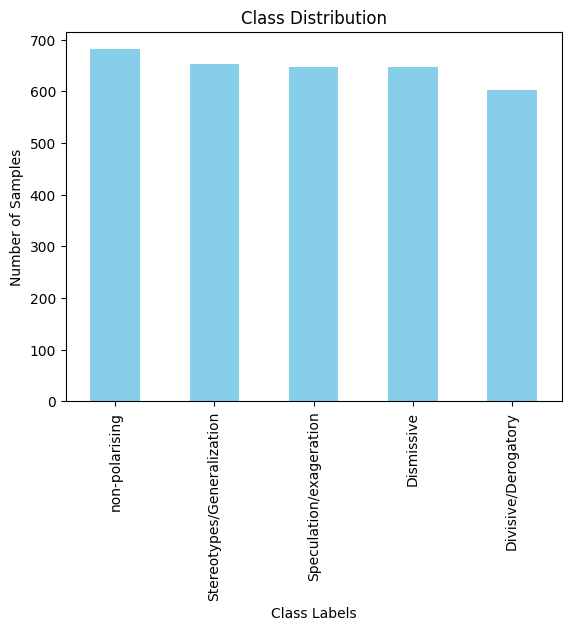

In [ ]:
# Visualizing the class distribution:
class_distribution = comments['label'].value_counts()
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
class_distribution

,count
label,
non-polarising,681
Stereotypes/Generalization,653
Speculation/exageration,647
Dismissive,646
Divisive/Derogatory,602


In [ ]:
# Encoding the 'label' column of the DataFrame using LabelEncoder:
#   This transforms categorical labels into numeric values and
#   the transformed labels are then stored back into the 'label' column of the DataFrame.

label_encoder = LabelEncoder()
comments['label'] = label_encoder.fit_transform(comments['label'])

print(comments[['text', 'label']].head())

                                                text  label
0  Its more about stubbornness and narcissism, th...      3
1  Can't I just find one person who identifies as...      3
2  They support bad people with bad intentions. M...      3
3  The most extreme examples of violence & abhorr...      3
4  all conservative people in general are really ...      3


In [ ]:
# Creating a mapping dictionary that associates the original categorical labels with their corresponding encoded numeric values:

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'Dismissive': 0, 'Divisive/Derogatory': 1, 'Speculation/exageration': 2, 'Stereotypes/Generalization': 3, 'non-polarising': 4}


# **Tokenisation**

In [ ]:
# Splitting the DataFrame into training and testing sets:
# Converting the training and testing DataFrames into Hugging Face `Dataset` objects
# to prepare them for use with the Hugging Face `transformers` library.

train_df, test_df = train_test_split(comments, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Loading the DistilBERT tokenizer using the pre-trained 'distilbert-base-uncased' model:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Defining a preprocessing function that tokenizes the 'text' field in the datasets.
# The function applies truncation and padding to ensure that all sequences have the same length (128 tokens):
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Applying the preprocessing function to the training and testing datasets using the `map` method:
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

# Creating a data collator to handle padding dynamically during training:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/2583 [00:00<?, ? examples/s]

Map:   0%|          | 0/646 [00:00<?, ? examples/s]

# **Model and Training**

In [ ]:
# Setting up the training configuration using the TrainingArguments class:
#   eval_strategy: Evaluate the model at the end of each epoch.
#   learning_rate: Learning rate for the optimizer.
#   per_device_train_batch_size & per_device_eval_batch_size: Batch sizes for training and evaluation on each device.
#   num_train_epochs: Number of epochs to train the model.
#   weight_decay: Applies weight decay for regularization to prevent overfitting.

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
)

# Initializing the DistilBERT model for sequence classification with the specified number of labels:

num_labels = len(comments['label'].unique())
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)


# Setting up the Trainer class with the model, training arguments, tokenized datasets, and data collator:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    data_collator=data_collator,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

model.to(device)

Using GPU


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# Begin the model training process using the Trainer class:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.796447
2,No log,0.804255
3,No log,0.798690
4,No log,0.896756
5,No log,0.911933


TrainOutput(global_step=405, training_loss=0.42338554476514273, metrics={'train_runtime': 141.8904, 'train_samples_per_second': 91.021, 'train_steps_per_second': 2.854, 'total_flos': 427726995897600.0, 'train_loss': 0.42338554476514273, 'epoch': 5.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.911933422088623, 'eval_runtime': 2.1561, 'eval_samples_per_second': 299.608, 'eval_steps_per_second': 9.74, 'epoch': 5.0}


# **Model Evaluation**

Accuracy: 0.7492
F1 Score (weighted): 0.7478


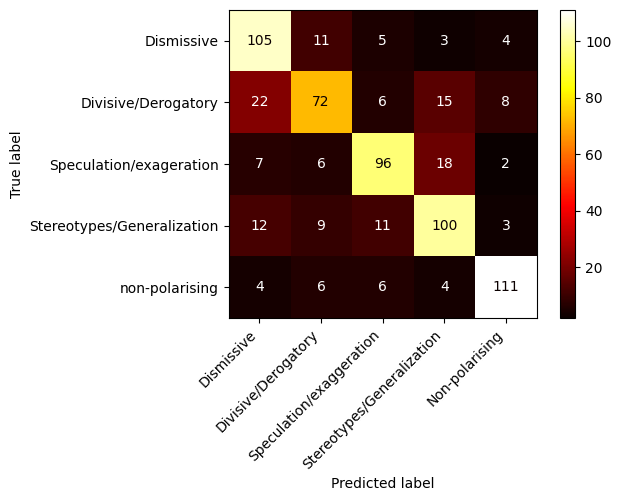

In [ ]:
# MODEL EVALUATION
predictions = trainer.predict(tokenized_test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# accuracy
accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy:.4f}")

# F1 score
f1 = f1_score(true_labels, preds, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")

# confusion matrix
fig, ax = plt.subplots(figsize=(6, 4))
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='hot', ax=ax)

ax.set_xticklabels(['Dismissive', 'Divisive/Derogatory', 'Speculation/exaggeration',
                    'Stereotypes/Generalization', 'Non-polarising'], rotation=45, ha='right')
plt.show()

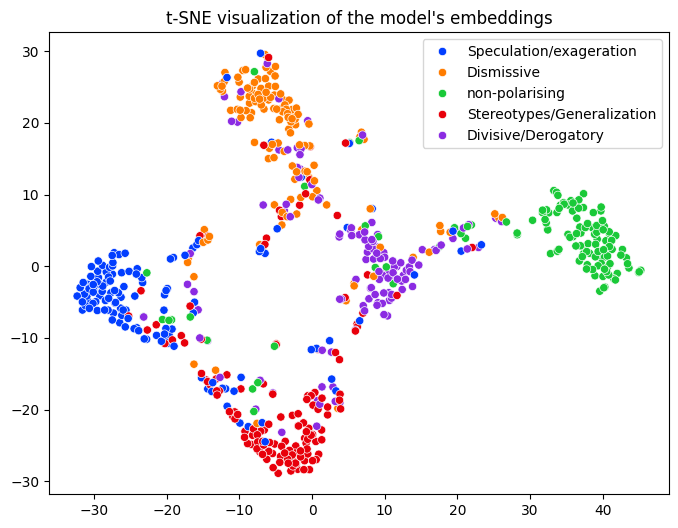

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

embeddings = predictions.predictions

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
                hue=label_encoder.inverse_transform(true_labels),
                palette="bright", legend="full")
plt.title("t-SNE visualization of the model's embeddings")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, preds, target_names=label_encoder.classes_, zero_division=0)

# classification report
print(report)

                            precision    recall  f1-score   support

                Dismissive       0.70      0.82      0.76       128
       Divisive/Derogatory       0.69      0.59      0.63       123
   Speculation/exageration       0.77      0.74      0.76       129
Stereotypes/Generalization       0.71      0.74      0.73       135
            non-polarising       0.87      0.85      0.86       131

                  accuracy                           0.75       646
                 macro avg       0.75      0.75      0.75       646
              weighted avg       0.75      0.75      0.75       646



# **Predictor Function For Multiclass Classifier**

In [ ]:
# PREDICTOR FUNCTION: This Function takes a text(comment)
# as an input and using the model, classifies the text accordingly.

def predictor(text):
    # Tokenizing the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

    # Moving the inputs to the same device as the model
    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    model.eval()

    # Getting the classification for the text
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class_index = torch.argmax(logits, dim=1).item()
    predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]

    return predicted_label


In [ ]:
# Demostration of the function

text0 = "I understand but their reaction is not okay"
text1 = "We must stop letting them in. They will take over the entire country. How stupid are these people..."
text2 = "It was a nice try, but it's kind of made the rioters look pretty pathetic. As they say, if you can't do the time, don't to do the crime."
text3 = "It’s why we need to keep challenging the racists on here. They are trying to provoke hate with lies and misinformation."
text4 = "There are a lot of right wing asshats on here coming out of the woodwork as for some strange reason, Reform UK seems to be an enabler for them to think it’s now OK to be a xenophobic shit."

prediction0 = predictor(text0)
prediction1 = predictor(text1)
prediction2 = predictor(text2)
prediction3 = predictor(text3)
prediction4 = predictor(text4)

print(f"Predicted class for Text0: {prediction0}")
print(f"Predicted class for Text1: {prediction1}")
print(f"Predicted class for Text2: {prediction2}")
print(f"Predicted class for Text3: {prediction3}")
print(f"Predicted class for Text4: {prediction4}")

Predicted class for Text0: non-polarising
Predicted class for Text1: Divisive/Derogatory
Predicted class for Text2: Dismissive
Predicted class for Text3: Dismissive
Predicted class for Text4: Divisive/Derogatory
